In [4]:
%autosave 2

Autosaving every 2 seconds


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv("data/btc_final_data.csv")
df.head()

,date,open,high,low,close,volume btc,volume usd,open_gold,high_gold,low_gold,...,ATR_14,VWAP,volatility_10,range,close_lag1,close_lag5,close_lag10,returns_lag1,returns_lag5,returns_lag10
0,2015-10-08 14:00:00,245.0,245.0,245.0,245.0,0.000000,0.000000,1144.84,1144.94,1144.57,...,0.0,244.5,0.000645,0.0,245.0,245.0,245.0,0.000000,0.0,0.0
1,2015-10-08 14:01:00,245.0,245.0,245.0,245.0,0.000000,0.000000,1144.50,1144.55,1143.94,...,0.0,244.5,0.000645,0.0,245.0,245.0,245.0,0.000000,0.0,0.0
2,2015-10-08 14:02:00,245.0,245.0,244.5,244.5,0.987223,241.375962,1143.96,1144.12,1143.93,...,0.0,244.5,0.000645,0.5,245.0,245.0,245.0,0.000000,0.0,0.0
3,2015-10-08 14:03:00,244.5,244.5,244.5,244.5,0.000000,0.000000,1143.77,1143.94,1143.73,...,0.0,244.5,0.000645,0.0,244.5,245.0,245.0,-0.002043,0.0,0.0
4,2015-10-08 14:04:00,244.5,244.5,244.5,244.5,0.000000,0.000000,1143.87,1143.97,1143.87,...,0.0,244.5,0.000645,0.0,244.5,245.0,245.0,0.000000,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37328 entries, 0 to 37327
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           37328 non-null  object 
 1   open           37328 non-null  float64
 2   high           37328 non-null  float64
 3   low            37328 non-null  float64
 4   close          37328 non-null  float64
 5   volume btc     37328 non-null  float64
 6   volume usd     37328 non-null  float64
 7   open_gold      37328 non-null  float64
 8   high_gold      37328 non-null  float64
 9   low_gold       37328 non-null  float64
 10  close_gold     37328 non-null  float64
 11  volume_gold    37327 non-null  float64
 12  SMA_20         37327 non-null  float64
 13  EMA_20         37327 non-null  float64
 14  TEMA_20        37327 non-null  float64
 15  MACD           37327 non-null  float64
 16  returns        37327 non-null  float64
 17  RSI_14         37327 non-null  float64
 18  BB_upp

In [8]:
ts = df.copy()
window = 60  # 60-minute rolling

# Rolling support/resistance
ts['support'] = ts['close'].rolling(window=window, min_periods=1).min()
ts['resistance'] = ts['close'].rolling(window=window, min_periods=1).max()

In [9]:
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)

In [10]:
support_levels = ts['support'].values.reshape(-1, 1)
resistance_levels = ts['resistance'].values.reshape(-1, 1)

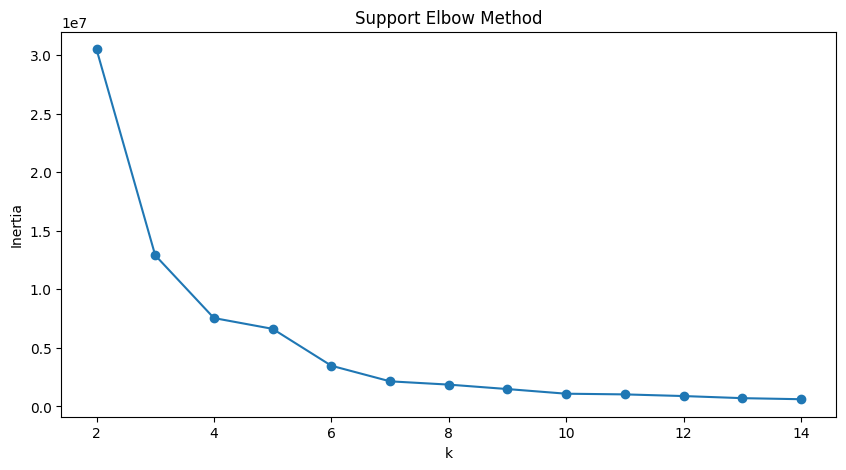

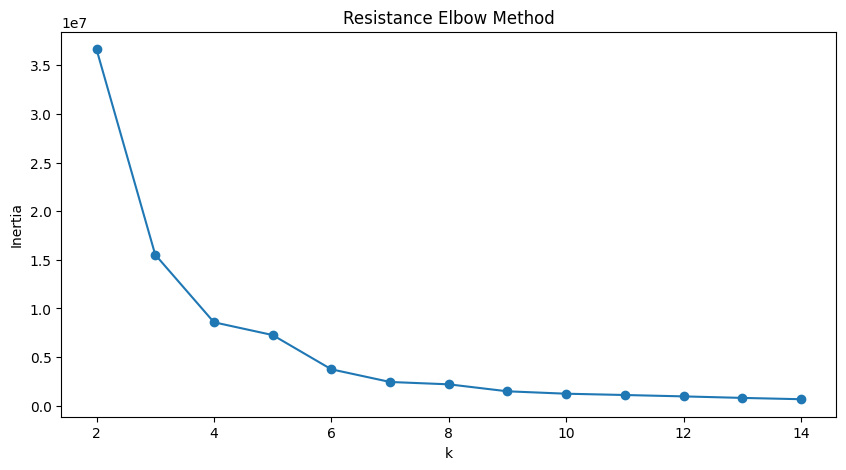

In [11]:
def plot_elbow_method(levels, max_k=15, title="Elbow Method"):
    """
    Plots the elbow method for K-Means clustering.
    """
    levels = levels.reshape(-1, 1)
    ks = range(2, max_k)
    inertia = []

    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(levels)
        inertia.append(km.inertia_)

    plt.figure(figsize=(10,5))
    plt.plot(ks, inertia, marker='o')
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.show()

plot_elbow_method(support_levels, max_k=15, title="Support Elbow Method")
plot_elbow_method(resistance_levels, max_k=15, title="Resistance Elbow Method")

In [12]:
def kmeans_clusters(levels, n_clusters=5, random_state=42):
    """
    Performs K-Means clustering on a 1D array of levels.

    Returns:
        cluster_centers (np.array): Sorted cluster centers
    """
    levels = levels.reshape(-1, 1)
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(levels)
    cluster_centers = np.sort(km.cluster_centers_.flatten())
    return cluster_centers

support_zones = kmeans_clusters(support_levels, n_clusters = 5, random_state=42)
resistance_zones = kmeans_clusters(resistance_levels, n_clusters = 5, random_state=42)

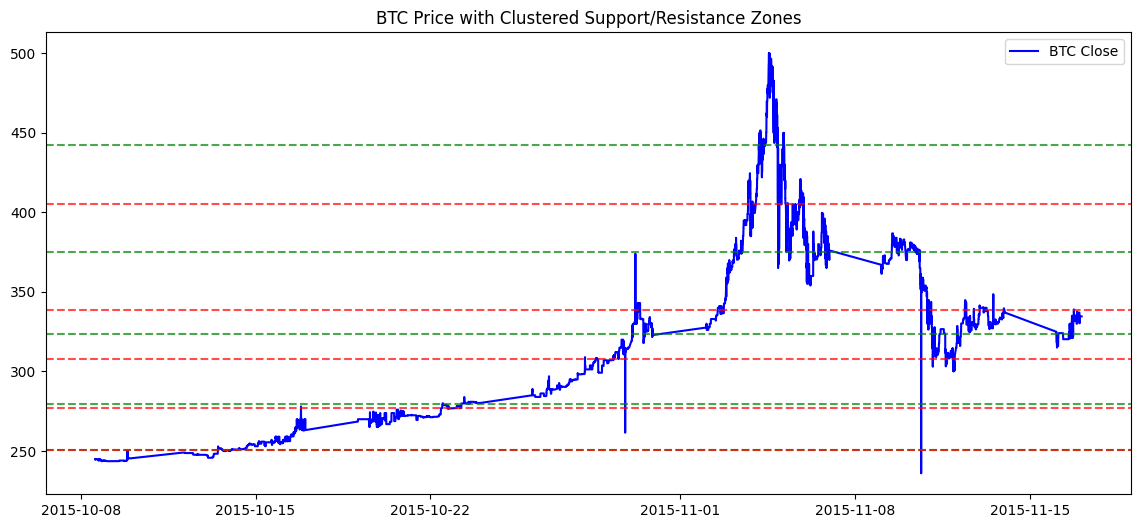

In [13]:
# Visualizing cluster (interactive)
plt.figure(figsize=(14,6))
plt.plot(ts['close'], label='BTC Close', color='blue')

for lvl in support_zones:
    plt.axhline(lvl, color='green', linestyle='--', alpha=0.7)
for lvl in resistance_zones:
    plt.axhline(lvl, color='red', linestyle='--', alpha=0.7)

plt.title("BTC Price with Clustered Support/Resistance Zones")
plt.legend()
plt.show()

In [14]:
#find dist_to_support and dist_to_resistance levels

ts['dist_to_support'] = ts['close'].apply(lambda x: np.min(np.abs(support_zones - x)))
ts['dist_to_resistance'] = ts['close'].apply(lambda x: np.min(np.abs(resistance_zones - x)))

In [15]:
#ts = ts.set_index('date')
ts = ts.sort_index()
ts.head()

,open,high,low,close,volume btc,volume usd,open_gold,high_gold,low_gold,close_gold,...,close_lag1,close_lag5,close_lag10,returns_lag1,returns_lag5,returns_lag10,support,resistance,dist_to_support,dist_to_resistance
date,,,,,,,,,,,,,,,,,,,,,
2015-10-08 14:00:00,245.0,245.0,245.0,245.0,0.000000,0.000000,1144.84,1144.94,1144.57,1144.65,...,245.0,245.0,245.0,0.000000,0.0,0.0,245.0,245.0,5.879844,5.562143
2015-10-08 14:01:00,245.0,245.0,245.0,245.0,0.000000,0.000000,1144.50,1144.55,1143.94,1143.96,...,245.0,245.0,245.0,0.000000,0.0,0.0,245.0,245.0,5.879844,5.562143
2015-10-08 14:02:00,245.0,245.0,244.5,244.5,0.987223,241.375962,1143.96,1144.12,1143.93,1143.93,...,245.0,245.0,245.0,0.000000,0.0,0.0,244.5,245.0,6.379844,6.062143
2015-10-08 14:03:00,244.5,244.5,244.5,244.5,0.000000,0.000000,1143.77,1143.94,1143.73,1143.80,...,244.5,245.0,245.0,-0.002043,0.0,0.0,244.5,245.0,6.379844,6.062143
2015-10-08 14:04:00,244.5,244.5,244.5,244.5,0.000000,0.000000,1143.87,1143.97,1143.87,1143.92,...,244.5,245.0,245.0,0.000000,0.0,0.0,244.5,245.0,6.379844,6.062143


In [16]:
returns = ts['close'].pct_change().dropna()
mu = returns.mean()
sigma = returns.std()

dt = 1  # 1-minute steps

S0 = ts['close'].iloc[-1]  # last closing price
T = 60*24  # e.g., simulate 1 day ahead in minutes
N = 1000  # number of simulations

simulated_paths = np.zeros((T, N))

for i in range(N):
    prices = [S0]
    for t in range(1, T):
        prices.append(prices[-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.random.normal()))
    simulated_paths[:, i] = prices

In [17]:
prob_support = np.percentile(simulated_paths, 5, axis=1)   # lower bound
prob_resistance = np.percentile(simulated_paths, 95, axis=1)  # upper bound

In [18]:
current_price = ts['close'].iloc[-1]
# Distance to next-step probabilistic support/resistance
dist_to_prob_support = current_price - prob_support[0]     # next-step support
dist_to_prob_resistance = prob_resistance[0] - current_price  # next-step resistance

In [19]:
ts_daily_indexed = ts.copy()
#ts_daily_indexed['date'] = pd.to_datetime(ts_daily_indexed['date'])
#ts_daily_indexed.set_index('date', inplace=True)


# Resample to daily OHLC (without modifying ts)
ts_daily = ts_daily_indexed.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume btc': 'sum',
    'volume usd': 'sum',
    'support': 'mean',      # or 'min'
    'resistance': 'mean'    # or 'max'
})

# Align Monte Carlo simulated paths to daily
simulated_daily_idx = np.linspace(0, simulated_paths.shape[0]-1, len(ts_daily), dtype=int)
prob_support_daily = np.percentile(simulated_paths[simulated_daily_idx, :], 5, axis=1)
prob_resistance_daily = np.percentile(simulated_paths[simulated_daily_idx, :], 95, axis=1)

# Plot
fig = go.Figure()

# Daily BTC Close Price
fig.add_trace(go.Scatter(
    x=ts_daily.index, y=ts_daily['close'],
    mode='lines',
    name='BTC Close Price',
    line=dict(color='blue')
))

# Historical support/resistance
fig.add_trace(go.Scatter(
    x=ts_daily.index, y=ts_daily['support'],
    mode='lines', name='Historical Support',
    line=dict(color='green', dash='dash')
))
fig.add_trace(go.Scatter(
    x=ts_daily.index, y=ts_daily['resistance'],
    mode='lines', name='Historical Resistance',
    line=dict(color='red', dash='dash')
))

# Monte Carlo probabilistic levels
fig.add_trace(go.Scatter(
    x=ts_daily.index, y=prob_support_daily,
    mode='lines', name='MC Support (5th percentile)',
    line=dict(color='green', dash='dot')
))
fig.add_trace(go.Scatter(
    x=ts_daily.index, y=prob_resistance_daily,
    mode='lines', name='MC Resistance (95th percentile)',
    line=dict(color='red', dash='dot')
))

fig.update_layout(
    title='Daily BTC Price with Historical & Probabilistic Support/Resistance',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

In [20]:
tbm_ts = ts.copy()
tbm_ts.index = pd.to_datetime(tbm_ts.index)

pt = 0.003  # 0.3% move for long
sl = 0.003  # 0.3% move for short

def triple_barrier_labels_correct(df, pt=0.003, sl=0.003, h=30):
    """
    Correct Triple-Barrier Method for minute-wise BTC data.

    df: DataFrame with 'close' prices
    pt: take-profit percentage
    sl: stop-loss percentage
    h: time barrier in minutes
    """
    labels = []
    close = df['close'].values
    n = len(close)

    for i in range(n):
        start_price = close[i]
        end_idx = min(i + h, n-1)
        future_prices = close[i:end_idx+1]

        # Calculate barrier prices
        P_target = start_price * (1 + pt)
        P_stop = start_price * (1 - sl)

        # Find indices of first hits
        profit_hit = np.where(future_prices >= P_target)[0]
        loss_hit = np.where(future_prices <= P_stop)[0]

        i_profit = profit_hit[0] if len(profit_hit) > 0 else h
        i_loss = loss_hit[0] if len(loss_hit) > 0 else h
        i_time = h

        first_hit = min(i_profit, i_loss, i_time)

        # Assign label
        if first_hit == i_profit:
            labels.append(1)    # Take profit
        elif first_hit == i_loss:
            labels.append(0)   # Stop loss

    return labels

tbm_ts['label'] = triple_barrier_labels_correct(tbm_ts, pt=0.003, sl=0.003, h=30)

In [21]:
label_counts = tbm_ts['label'].value_counts()
print(label_counts)
print(tbm_ts.columns)

label
1    30741
0     6587
Name: count, dtype: int64
Index(['open', 'high', 'low', 'close', 'volume btc', 'volume usd', 'open_gold',
       'high_gold', 'low_gold', 'close_gold', 'volume_gold', 'SMA_20',
       'EMA_20', 'TEMA_20', 'MACD', 'returns', 'RSI_14', 'BB_upper',
       'BB_lower', 'BB_width', 'ATR_14', 'VWAP', 'volatility_10', 'range',
       'close_lag1', 'close_lag5', 'close_lag10', 'returns_lag1',
       'returns_lag5', 'returns_lag10', 'support', 'resistance',
       'dist_to_support', 'dist_to_resistance', 'label'],
      dtype='object')


In [22]:
tbm_ts = tbm_ts[tbm_ts['label'].isin([0, 1])]
tbm_ts['label'] = tbm_ts['label'].astype(int)

In [23]:
# Handle Class Imbalance
pos = minority = 0
neg = majority = 1

pos_count = (tbm_ts['label'] == 1).sum()
neg_count = (tbm_ts['label'] == 0).sum()

scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 0.21427409648352364


In [24]:
# Features + Target
X = tbm_ts.drop(columns=['label'])
y = tbm_ts['label']

# Time-based train/test split
split_index = int(len(tbm_ts) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 4. XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,  # handles class imbalance
    'tree_method': 'hist',
    'seed': 42
}


# Train XGBoost
num_boost_round = 300

evals = [(dtrain, 'train'), (dtest, 'test')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    verbose_eval=50
)


# Predictions
y_proba = model.predict(dtest)
y_pred = (y_proba > 0.5).astype(int)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

[0]	train-logloss:0.59210	test-logloss:0.64756
[50]	train-logloss:0.22529	test-logloss:0.68902
[100]	train-logloss:0.15905	test-logloss:0.75497
[150]	train-logloss:0.11963	test-logloss:0.84632
[200]	train-logloss:0.09178	test-logloss:0.91275
[250]	train-logloss:0.07283	test-logloss:0.96449
[299]	train-logloss:0.06012	test-logloss:1.02154
Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.19      0.26      2125
           1       0.74      0.90      0.81      5341

    accuracy                           0.70      7466
   macro avg       0.59      0.55      0.54      7466
weighted avg       0.65      0.70      0.66      7466

Confusion Matrix:

[[ 399 1726]
 [ 514 4827]]


In [25]:
features = tbm_ts.drop(columns=['label']).values
labels = tbm_ts['label'].values

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

look_back = 30  # 30 timesteps per sample

X, y = [], []
for i in range(look_back, len(features_scaled)):
    X.append(features_scaled[i-look_back:i])
    y.append(labels[i])

X = np.array(X, dtype=np.float32)  # (samples, timesteps, features)
y = np.array(y, dtype=np.int64)    # integer labels

print("X shape:", X.shape, "y shape:", y.shape)

# Train/test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# define lstm
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=2, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_dim=X.shape[2]).to(device)

# Loss and optimizer

# Handle class imbalance
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
epochs = 4
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}")

# Evaluate
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred_list.extend(preds)
        y_true_list.extend(yb.numpy())

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

X shape: (37298, 30, 34) y shape: (37298,)
Epoch 1/4, Loss: 0.6492
Epoch 2/4, Loss: 0.6220
Epoch 3/4, Loss: 0.5945
Epoch 4/4, Loss: 0.5829
              precision    recall  f1-score   support

           0       0.33      0.73      0.46      2125
           1       0.80      0.41      0.54      5335

    accuracy                           0.50      7460
   macro avg       0.56      0.57      0.50      7460
weighted avg       0.66      0.50      0.52      7460

[[1556  569]
 [3128 2207]]
